## Basic setup

In [1]:
## Import packages
import pandas as pd
import numpy as np
import nltk
import re
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load wine dataset 
df = pd.read_csv('winemag-data_first150k.csv')
df.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


In [3]:
df[df['variety']=='Rh\xc3\xb4ne-style Red Blend']['variety'] = 'Rhone-style Red Blend'

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [4]:
def remove_weird_char(string):
    words = string.lower().split()
    refined = []
    for i in words:
        refined.append(re.sub("[^\w-]+", "", i))
        sentence = ' '.join([word for word in refined])
    return(sentence)

In [5]:
#Clean up that description column
df['description'] = df['description'].str.lower()
df['description'] = df['description'].apply(remove_weird_char)

df['description'].head()

0    this tremendous 100 varietal wine hails from o...
1    ripe aromas of fig blackberry and cassis are s...
2    mac watson honors the memory of a wine once ma...
3    this spent 20 months in 30 new french oak and ...
4    this is the top wine from la bgude named after...
Name: description, dtype: object

In [6]:
## Remove stopwords
from nltk.corpus import stopwords
cachedStopWords = stopwords.words("english")
cachedStopWords.append('wine')
def rmStopWords(text):
        text = ' '.join([word for word in text.split() if word not in cachedStopWords])
        return(text)

In [7]:
df['description']=df['description'].apply(rmStopWords)

In [8]:
df = df[['variety', 'description', 'price']]
df.head()

,variety,description,price
0,Cabernet Sauvignon,tremendous 100 varietal hails oakville aged th...,235.0
1,Tinta de Toro,ripe aromas fig blackberry cassis softened swe...,110.0
2,Sauvignon Blanc,mac watson honors memory made mother tremendou...,90.0
3,Pinot Noir,spent 20 months 30 new french oak incorporates...,65.0
4,Provence red blend,top la bgude named highest point vineyard 1200...,66.0


## Calculate lift values

In [9]:
df['variety'].value_counts()[:25]

Chardonnay                       14482
Pinot Noir                       14291
Cabernet Sauvignon               12800
Red Blend                        10062
Bordeaux-style Red Blend          7347
Sauvignon Blanc                   6320
Syrah                             5825
Riesling                          5524
Merlot                            5070
Zinfandel                         3799
Sangiovese                        3345
Malbec                            3208
White Blend                       2824
Rosé                              2817
Tempranillo                       2556
Nebbiolo                          2241
Portuguese Red                    2216
Sparkling Blend                   2004
Shiraz                            1970
Corvina, Rondinella, Molinara     1682
Rhône-style Red Blend             1505
Barbera                           1365
Pinot Gris                        1365
Cabernet Franc                    1363
Sangiovese Grosso                 1346
Name: variety, dtype: int

In [10]:
top_varieties = list(df['variety'].value_counts()[:25].index)

mask = df['variety'].isin(top_varieties)
new_df = df[mask]
new_df.head()

,variety,description,price
0,Cabernet Sauvignon,tremendous 100 varietal hails oakville aged th...,235.0
2,Sauvignon Blanc,mac watson honors memory made mother tremendou...,90.0
3,Pinot Noir,spent 20 months 30 new french oak incorporates...,65.0
8,Pinot Noir,re-named vineyard formerly bottled delancellot...,65.0
9,Pinot Noir,producer sources two blocks vineyard wineone h...,60.0


In [11]:
#dealing with top 25 vatieties
len(top_varieties)

25

In [12]:
all_desc = new_df['description'].str.cat(sep=' ')

pos_df = pd.DataFrame(all_desc.split(), columns=['word'])
pos_df['word'].value_counts()[:20]

flavors    61718
fruit      44565
finish     29191
tannins    27792
cherry     26710
aromas     25914
acidity    24047
palate     21410
ripe       21177
black      20950
drink      18948
dry        18683
spice      17896
oak        17412
rich       16876
sweet      16222
red        15624
notes      15345
soft       13963
good       13865
Name: word, dtype: int64

In [13]:
attribute_list = pos_df['word'].value_counts()[:20].index

In [14]:
#calculate lift values

def calc_lift(a, b):
    total_size = len(df)
    filter_a = df[df['variety']==a]
    num_a = len(filter_a)
    num_b = len(df[df['description'].str.contains(b)])
    num_a_b = len(filter_a['description'][filter_a['description'].str.contains(b)])
    if num_a_b==0:
        return .2
    return total_size*float(num_a_b)/float(num_a*num_b)

In [15]:
lift_df = pd.DataFrame(columns=top_varieties, index=attribute_list)

for attribute, series in list(lift_df.iterrows()):
    for variety in series.index:
        lift_df[variety].loc[attribute] = calc_lift(variety, attribute)

lift_df

,Chardonnay,Pinot Noir,Cabernet Sauvignon,Red Blend,Bordeaux-style Red Blend,Sauvignon Blanc,Syrah,Riesling,Merlot,Zinfandel,...,Nebbiolo,Portuguese Red,Sparkling Blend,Shiraz,"Corvina, Rondinella, Molinara",Rhône-style Red Blend,Barbera,Pinot Gris,Cabernet Franc,Sangiovese Grosso
flavors,1.18142,1.11135,1.19422,0.87089,0.708477,1.26915,1.12957,1.01437,1.1682,1.30949,...,0.203857,0.632153,1.13277,0.905026,0.367751,0.942886,0.419095,1.09439,1.02332,0.2493
fruit,1.05548,0.918733,0.823677,0.958115,1.3923,1.16807,1.00323,0.914565,0.902196,0.646832,...,0.778918,1.70963,0.708292,1.10576,0.998762,0.928142,1.10749,1.13303,0.987216,0.984445
finish,0.992232,0.79859,0.987778,0.960375,0.521282,1.26491,0.974459,1.63065,1.08394,0.835554,...,0.786586,0.261128,1.1016,1.79468,0.538916,1.43573,0.686125,1.22522,1.05278,0.397606
tannins,0.0344001,1.18253,1.88859,1.37286,2.61356,0.0137755,1.41324,0.00875584,1.59412,1.2617,...,2.45182,3.03823,0.0120677,1.36263,0.600996,1.59403,0.687417,0.0106302,1.97301,1.04568
cherry,0.00366616,2.14804,1.36165,1.72354,0.502573,0.00305486,1.22966,0.0463095,2.14677,1.27178,...,2.04611,0.148111,0.284205,0.83303,2.25264,1.75107,1.80337,0.0106081,1.92288,2.41692
aromas,0.694951,0.391973,0.783938,1.45942,0.375707,0.959249,0.705318,0.839519,0.859157,0.23471,...,2.6329,0.177122,1.37953,1.26907,1.97337,0.722867,1.70966,0.456326,0.766875,1.93665
acidity,1.51651,1.21039,0.409767,0.454176,1.23246,1.38418,0.496008,1.46997,0.496309,0.43867,...,0.617247,2.05372,0.968227,0.277987,0.241382,0.555226,1.46645,1.18284,0.8486,0.624321
palate,0.857628,0.611921,0.907788,1.32543,0.400185,0.963888,0.765766,1.62228,0.936402,0.291549,...,1.53664,0.124954,1.3139,1.29824,0.404079,1.03032,0.925762,1.06223,1.00838,0.370296
ripe,1.1629,1.00893,1.15446,0.93124,1.5286,0.981256,1.01474,0.966535,1.01008,1.32506,...,0.836679,1.75564,0.355393,0.58287,0.901588,0.80481,0.72763,0.97254,1.03795,0.795494
black,0.0040928,0.676042,2.32272,1.60697,1.93297,0.00687754,2.04865,0.0150218,1.57435,1.6975,...,1.24839,1.73679,0.00394357,1.5846,1.25921,1.49657,1.73112,0.0231587,1.20022,1.40033


In [16]:
s = pos_df['word'].value_counts()
len(s[s>100])

2665

## Bryan's stuff

In [17]:
def print_top10(vectorizer, clf, class_labels):
    """Prints features with the highest coefficient values, per class"""
    final = set()
    feature_names = vectorizer.get_feature_names()
    for i, class_label in enumerate(class_labels):
        top10 = np.argsort(clf.coef_[i])[-10:]
        final = final.union(set(feature_names[j] for j in top10))
    return final

In [18]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from operator import itemgetter
from sklearn.metrics import classification_report

vectorizer = CountVectorizer()


trainset_size = int(round(len(new_df)*0.80))
X_train = new_df["description"].iloc[1:trainset_size,]
y_train = new_df["variety"].iloc[1:trainset_size,]

X_test = new_df["description"].iloc[trainset_size:,]
y_test = new_df["variety"].iloc[trainset_size:,]

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [19]:
nb_classifier = MultinomialNB().fit(X_train, y_train)

y_nb_predicted = nb_classifier.predict(X_test)

In [20]:
predictive_attributes = list(print_top10(vectorizer, nb_classifier, top_varieties))
len(predictive_attributes)

67

## Vectorize each variety

In [21]:
#calculate vectors

def calc_vect(a, b):
    temp_string = df[df['variety']==a]['description'].str.cat(sep=' ')
    return temp_string.count(b)

# note the attribute features chosen as the words most predictive in Naive Bayes model

In [22]:
vector_df = pd.DataFrame(columns=top_varieties, index=predictive_attributes)

for attribute, series in list(vector_df.iterrows()):
    for variety in series.index:
        vector_df[variety].loc[attribute] = calc_vect(variety, attribute)

vector_df

,Chardonnay,Pinot Noir,Cabernet Sauvignon,Red Blend,Bordeaux-style Red Blend,Sauvignon Blanc,Syrah,Riesling,Merlot,Zinfandel,...,Nebbiolo,Portuguese Red,Sparkling Blend,Shiraz,"Corvina, Rondinella, Molinara",Rhône-style Red Blend,Barbera,Pinot Gris,Cabernet Franc,Sangiovese Grosso
malbec,0,4,149,494,278,2,9,0,45,0,...,0,3,3,0,0,1,0,0,8,0
apple,8200,97,33,51,2,1712,39,2475,17,3,...,37,2,797,4,131,11,23,541,21,16
sweet,2423,2053,2600,1611,1237,1065,957,1839,879,1234,...,156,280,591,206,405,184,225,287,248,210
bright,1165,789,307,876,320,481,305,438,197,92,...,406,127,155,95,289,115,382,85,95,384
brunello,0,0,0,5,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,773
ros,391,1014,320,475,121,99,245,213,135,63,...,331,35,308,152,66,91,27,51,72,345
cola,20,4115,2728,2200,830,5,1290,4,1045,1062,...,502,147,27,456,623,286,229,5,196,387
flavors,8867,8132,7886,4556,2698,4113,3453,2860,3083,2539,...,234,741,1161,912,315,721,296,764,736,170
shiraz,3,7,4,153,1,3,23,3,1,0,...,0,2,4,966,0,38,0,0,0,0
noir,29,3638,20,109,13,19,24,0,10,24,...,3,5,309,0,0,9,0,5,4,0


In [23]:
#calculate cosine similarities 

from scipy import spatial
def calc_cos(series_A, series_B):
    sim = round(1 - spatial.distance.cosine(series_A, series_B),3)
    if sim==1:
        return np.nan
    return sim

In [24]:
cos_df = pd.DataFrame(columns=top_varieties, index=top_varieties)

for variety_A, series in list(cos_df.iterrows()):
    for variety_B in series.index:
        cos_df[variety_B].loc[variety_A] = calc_cos(vector_df[variety_B], vector_df[variety_A])

cos_df

,Chardonnay,Pinot Noir,Cabernet Sauvignon,Red Blend,Bordeaux-style Red Blend,Sauvignon Blanc,Syrah,Riesling,Merlot,Zinfandel,...,Nebbiolo,Portuguese Red,Sparkling Blend,Shiraz,"Corvina, Rondinella, Molinara",Rhône-style Red Blend,Barbera,Pinot Gris,Cabernet Franc,Sangiovese Grosso
Chardonnay,NaN,0.633,0.523,0.511,0.59,0.831,0.552,0.814,0.588,0.475,...,0.462,0.598,0.827,0.581,0.511,0.545,0.517,0.829,0.579,0.442
Pinot Noir,0.633,NaN,0.747,0.747,0.749,0.638,0.789,0.601,0.834,0.727,...,0.722,0.737,0.727,0.776,0.734,0.795,0.709,0.682,0.793,0.695
Cabernet Sauvignon,0.523,0.747,NaN,0.881,0.843,0.534,0.846,0.494,0.86,0.753,...,0.704,0.693,0.553,0.791,0.689,0.779,0.709,0.482,0.904,0.655
Red Blend,0.511,0.747,0.881,NaN,0.835,0.562,0.832,0.502,0.865,0.708,...,0.772,0.693,0.603,0.798,0.77,0.877,0.744,0.492,0.883,0.727
Bordeaux-style Red Blend,0.59,0.749,0.843,0.835,NaN,0.621,0.789,0.549,0.818,0.67,...,0.686,0.935,0.548,0.743,0.668,0.768,0.692,0.572,0.859,0.638
Sauvignon Blanc,0.831,0.638,0.534,0.562,0.621,NaN,0.585,0.84,0.606,0.509,...,0.475,0.614,0.819,0.613,0.51,0.568,0.545,0.823,0.605,0.452
Syrah,0.552,0.789,0.846,0.832,0.789,0.585,NaN,0.536,0.86,0.801,...,0.738,0.743,0.597,0.85,0.741,0.898,0.762,0.538,0.789,0.702
Riesling,0.814,0.601,0.494,0.502,0.549,0.84,0.536,NaN,0.568,0.498,...,0.48,0.549,0.835,0.579,0.494,0.557,0.518,0.84,0.564,0.435
Merlot,0.588,0.834,0.86,0.865,0.818,0.606,0.86,0.568,NaN,0.771,...,0.769,0.722,0.628,0.833,0.767,0.837,0.754,0.552,0.85,0.722
Zinfandel,0.475,0.727,0.753,0.708,0.67,0.509,0.801,0.498,0.771,NaN,...,0.625,0.617,0.552,0.719,0.656,0.73,0.646,0.487,0.702,0.606


In [25]:
#most similar varieties using cosine similarity
cos_df.idxmax(axis=0)

Chardonnay                                     Sauvignon Blanc
Pinot Noir                                              Merlot
Cabernet Sauvignon                              Cabernet Franc
Red Blend                                       Cabernet Franc
Bordeaux-style Red Blend                        Portuguese Red
Sauvignon Blanc                                       Riesling
Syrah                                    Rhône-style Red Blend
Riesling                                       Sauvignon Blanc
Merlot                                              Sangiovese
Zinfandel                                                Syrah
Sangiovese                                            Nebbiolo
Malbec                                             Tempranillo
White Blend                                    Sauvignon Blanc
Rosé                                                Pinot Noir
Tempranillo                                             Malbec
Nebbiolo                                            San

## Most prevalent words for Chardonnay and Sauvignon Blanc

In [26]:
list_a = []
list_b = []
for attribute in predictive_attributes:
    list_a.append(float(sum(df[df['variety']=='Chardonnay']['description'].str.contains(str(attribute))))/float(len(df[df['variety']=='Chardonnay'])))
    list_b.append(float(sum(df[df['variety']=='Sauvignon Blanc']['description'].str.contains(str(attribute))))/float(len(df[df['variety']=='Sauvignon Blanc'])))

In [27]:
new = pd.DataFrame([predictive_attributes, list_a, list_b]).T
new.columns = ['attribute', 'count_a', 'count_b']
new['avg'] = (new['count_a']+new['count_b'])/2.0
new['range'] = abs(new['count_a']-new['count_b'])
new.sort_values('avg', ascending=False, inplace=True)

In [28]:
new[new['avg']>.2].sort_values('range')

,attribute,count_a,count_b,avg,range
10,acidity,0.321226,0.293196,0.307211,0.0280301
38,ripe,0.240022,0.202532,0.221277,0.0374905
7,flavors,0.58445,0.627848,0.606149,0.0433984
54,fruit,0.51457,0.569462,0.542016,0.0548922
28,crisp,0.185541,0.264241,0.224891,0.0786998
51,finish,0.296644,0.378165,0.337404,0.0815204
64,fresh,0.157506,0.252848,0.205177,0.0953422
22,citrus,0.183055,0.316456,0.249755,0.133401
1,apple,0.482461,0.243513,0.362987,0.238948
45,oak,0.352576,0.0838608,0.218218,0.268715


## Worst matches

In [29]:
#least similar varieties using cosine similarity
cos_df.idxmin(axis=0)

Chardonnay                       Sangiovese Grosso
Pinot Noir                             White Blend
Cabernet Sauvignon                     White Blend
Red Blend                               Pinot Gris
Bordeaux-style Red Blend           Sparkling Blend
Sauvignon Blanc                  Sangiovese Grosso
Syrah                                  White Blend
Riesling                         Sangiovese Grosso
Merlot                                 White Blend
Zinfandel                              White Blend
Sangiovese                              Pinot Gris
Malbec                                 White Blend
White Blend                              Zinfandel
Rosé                                     Zinfandel
Tempranillo                            White Blend
Nebbiolo                                Pinot Gris
Portuguese Red                     Sparkling Blend
Sparkling Blend                     Portuguese Red
Shiraz                                 White Blend
Corvina, Rondinella, Molinara  

## Most shared attributes between Chardonnay and Sangiovese Grosso

In [30]:
list_a = []
list_b = []
for attribute in predictive_attributes:
    list_a.append(float(sum(df[df['variety']=='Chardonnay']['description'].str.contains(str(attribute))))/float(len(df[df['variety']=='Chardonnay'])))
    list_b.append(float(sum(df[df['variety']=='Sangiovese Grosso']['description'].str.contains(str(attribute))))/float(len(df[df['variety']=='Sangiovese Grosso'])))

In [31]:
new = pd.DataFrame([predictive_attributes, list_a, list_b]).T
new.columns = ['attribute', 'count_a', 'count_b']
new['avg'] = (new['count_a']+new['count_b'])/2.0
new['range'] = abs(new['count_a']-new['count_b'])
new.sort_values('avg', ascending=False, inplace=True)

In [32]:
new[new['avg']>.1].sort_values('range', ascending=False)

,attribute,count_a,count_b,avg,range
4,brunello,0,0.565379,0.282689,0.565379
11,cherry,0.000759564,0.500743,0.250751,0.499983
1,apple,0.482461,0.0111441,0.246803,0.471317
7,flavors,0.58445,0.123328,0.353889,0.461121
62,berry,0.00317636,0.447251,0.225214,0.444075
27,spice,0.113382,0.527489,0.320435,0.414107
15,black,0.00103577,0.354383,0.17771,0.353348
29,chardonnay,0.349606,0,0.174803,0.349606
59,aromas,0.162892,0.453938,0.308415,0.291046
6,cola,0.00117387,0.271917,0.136545,0.270743


## Words most predictive of higher prices

In [47]:
def print_top10(vectorizer, clf, class_labels):
    """Prints features with the highest coefficient values, per class"""
    final = set()
    feature_names = vectorizer.get_feature_names()
    
    stuff = np.argsort(clf.coef_[0])[-20:]
    return set(feature_names[j] for j in stuff)

In [50]:
filtered = new_df[new_df['variety']=='Riesling']
filtered.sort_values('price', ascending=False, inplace=True)
filtered['target'] = np.nan
filtered.replace(to_replace='target', value='hi', inplace=True, limit=int(round(len(filtered)*0.10)))
filtered.replace(to_replace={'target':{np.nan:'lo'}}, inplace=True)

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after remo

In [51]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from operator import itemgetter
from sklearn.metrics import classification_report

vectorizer = CountVectorizer()

trainset_size = int(round(len(filtered)*0.80))
X_train = filtered["description"].iloc[1:trainset_size,]
y_train = filtered["target"].iloc[1:trainset_size,]

X_test = filtered["description"].iloc[trainset_size:,]
y_test = filtered["target"].iloc[trainset_size:,]

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [52]:
nb_classifier = MultinomialNB().fit(X_train, y_train)

y_nb_predicted = nb_classifier.predict(X_test)

In [53]:
predictive_attributes = list(print_top10(vectorizer, nb_classifier, ['hi']))
print predictive_attributes

[u'dry', u'flavors', u'riesling', u'palate', u'crisp', u'peach', u'ripe', u'citrus', u'sweet', u'notes', u'aromas', u'long', u'honey', u'finish', u'fruit', u'acidity', u'apple', u'fresh', u'lemon', u'lime']


## Wordcloud to make Meyappan happy

In [39]:
from wordcloud import WordCloud,STOPWORDS

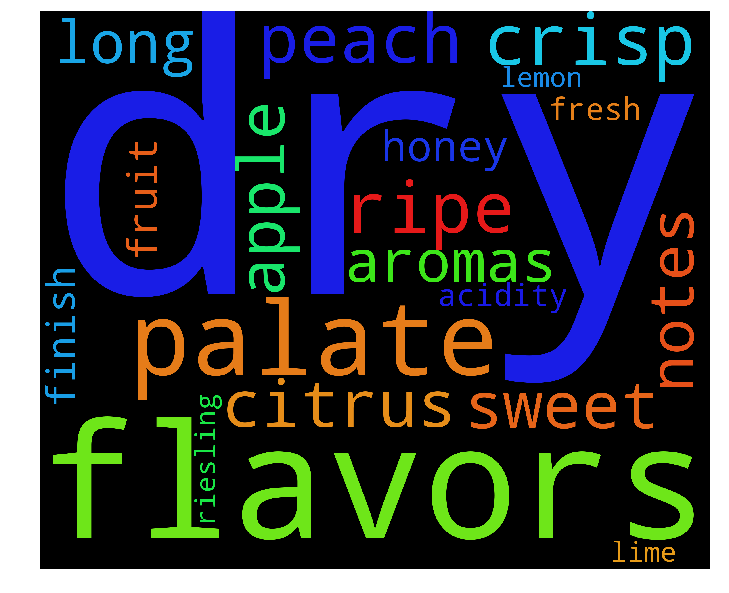

In [54]:
wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', width=3000, height=2500).generate(" ".join([word for word in predictive_attributes]))
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()